In [1]:
import glob

import numpy             as np
import matplotlib.pyplot as plt

from collections import defaultdict

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import compute_baseline_float

from CCfit import fit
from CCfit import shifted_gauss

from CCplot import plot1d
from CCplot import plot2d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots
from CCplot import set_ylimits

from CCdatabase import paper_signals
from CCdatabase import californication_irradiation_mapping
from CCdatabase import position_correction

from CCio import load_all

In [2]:
%matplotlib inline

auto_plot_style()

In [3]:
%load_ext autoreload
%autoreload 2

# All data

In [5]:
filenames_pre  = glob.glob("/home/gonzalo/data/CC/Californication/*pre*.h5")
filenames_post = glob.glob("/home/gonzalo/data/CC/Californication/*post*.h5")
experiment     = load_all(filenames_pre, filenames_post)

In [6]:
experiment.pre.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        7        2          0        1000    516       0.1   
1       False        7        2          0        1000    516       0.1   
2       False        7        2          0        1000    516       0.1   
3       False        7        2          0        1000    516       0.1   
4       False        7        2          0        1000    516       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub   rate  \
0  275.0  0.000008  287.75    3228  Sp_B1_004           Sp   -58.0 -580.0   
1  275.0  0.000008  288.25    3232  Sp_B1_004           Sp   -54.0 -540.0   
2  275.0  0.000008  288.75    3211  Sp_B1_004           Sp   -75.0 -750.0   
3  275.0  0.000008  289.50    3222  Sp_B1_004           Sp   -64.0 -640.0   
4  275.0  0.000008  290.00    3209  Sp_B1_004           Sp   -77.0 -770.0   

        quantar       dquanta  wheel_no  
0  1.104294e+15 -5.252226e-13         0  
1  1.104294e+15 -4.890003e-13         0  
2  1.104294e+15 -6.791671e-13         0  
3  1.104294e+15 -5.795559e-13         0  
4  1.104294e+15 -6.972783e-13         0

In [7]:
experiment.post.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        6        2          0        1000    114       0.1   
1       False        6        2          0        1000    114       0.1   
2       False        6        2          0        1000    114       0.1   
3       False        6        2          0        1000    114       0.1   
4       False        6        2          0        1000    114       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub    rate  \
0  275.0  0.000008  287.75    3155  Sp_B2_038           Sp  -134.0 -1340.0   
1  275.0  0.000008  288.25    3145  Sp_B2_038           Sp  -144.0 -1440.0   
2  275.0  0.000008  288.75    3149  Sp_B2_038           Sp  -140.0 -1400.0   
3  275.0  0.000008  289.50    3123  Sp_B2_038           Sp  -166.0 -1660.0   
4  275.0  0.000008  290.00    3122  Sp_B2_038           Sp  -167.0 -1670.0   

        quantar       dquanta  wheel_no  
0  1.081312e+15 -1.239235e-12         3  
1  1.081312e+15 -1.331716e-12         3  
2  1.081312e+15 -1.294723e-12         3  
3  1.081312e+15 -1.535172e-12         3  
4  1.081312e+15 -1.544420e-12         3

In [94]:
def subtract_baseline(data):
    return data - compute_baseline_float(data)

def plot2(x, y, z, title=""):
    ux = np.unique(x); ux.sort()
    uy = np.unique(y); uy.sort()
    
    xbins = ux - np.diff(ux)[0] / 2
    ybins = uy - np.diff(uy)[0] / 2
    
    plt.hist2d(x, y, (xbins, ybins), weights=z)
    plt.xlabel("Excitation wl (nm)")
    plt.ylabel("Emission wl (nm)")
    plt.title(title)
    return plt.colorbar()
    
def plot_2d(df, crystal_type, **overrides):
    selections = dict(crystal_type = crystal_type,
                      exposure     =            1,
                      exp_index    =            0,
                      grating      =            2,
                      slit_width   =         1000,
                      looparound   =        False)
    selections.update(overrides)

    gb       = filter_df(df, selections).groupby("crystal_id")
    crystals = list(gb.groups.keys())
    n        = len(crystals)

    plt.figure(figsize=figure_sizes[n])
    for k, crystal_id in enumerate(crystals, start=1):
        pre  = gb.get_group(crystal_id)
        sg_pre  = pre#longer_than_exwl(pre)

        plt.subplot(*subplots[n], k)
        for sg in np.split(sg_pre, len(sg_pre)//1600):
            plt.plot(sg.em_wl, np.abs(subtract_baseline(sg.dquanta.values)))
#        plot2 (sg_pre .ex_wl  .values,
#               sg_pre .em_wl  .values,
#               np.abs(subtract_baseline(sg_pre .dquanta.values)),
#               title  = crystal_id + " " + californication_irradiation_mapping[crystal_id])
    plt.tight_layout()

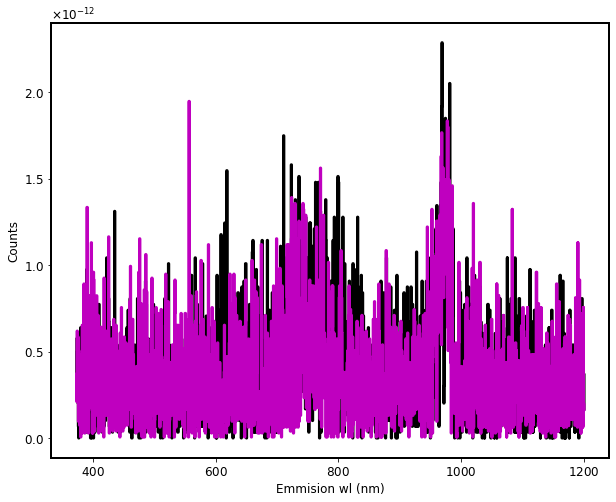

In [88]:
exwl       = 360
grating    = 2
crystal    = "CaF_B1_292"
exposure   = 1
selections = dict(crystal_id=crystal, ex_wl=exwl, grating=grating, looparound=False, exposure=exposure, exp_index=0)

pre  = experiment.pre .crystals
post = experiment.post.crystals
pre  = filter_df(pre , selections)
post = filter_df(post, selections)

plot1d(pre .em_wl, np.abs(subtract_baseline(pre .dquanta.values)))
plot1d(post.em_wl, np.abs(subtract_baseline(post.dquanta.values)))


# Sp

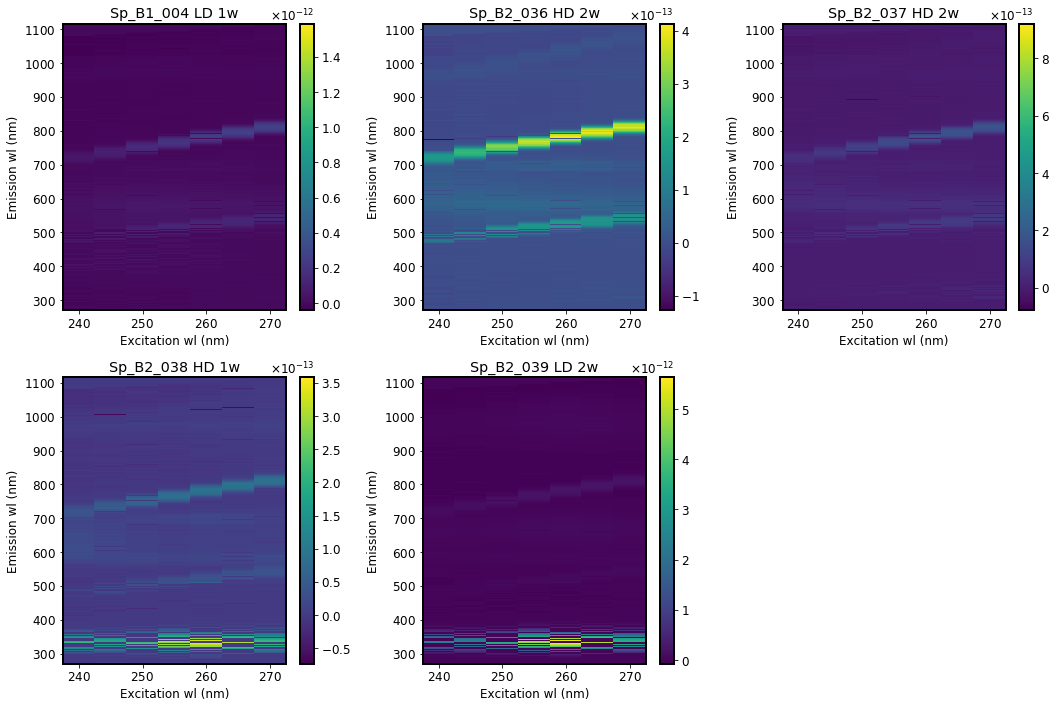

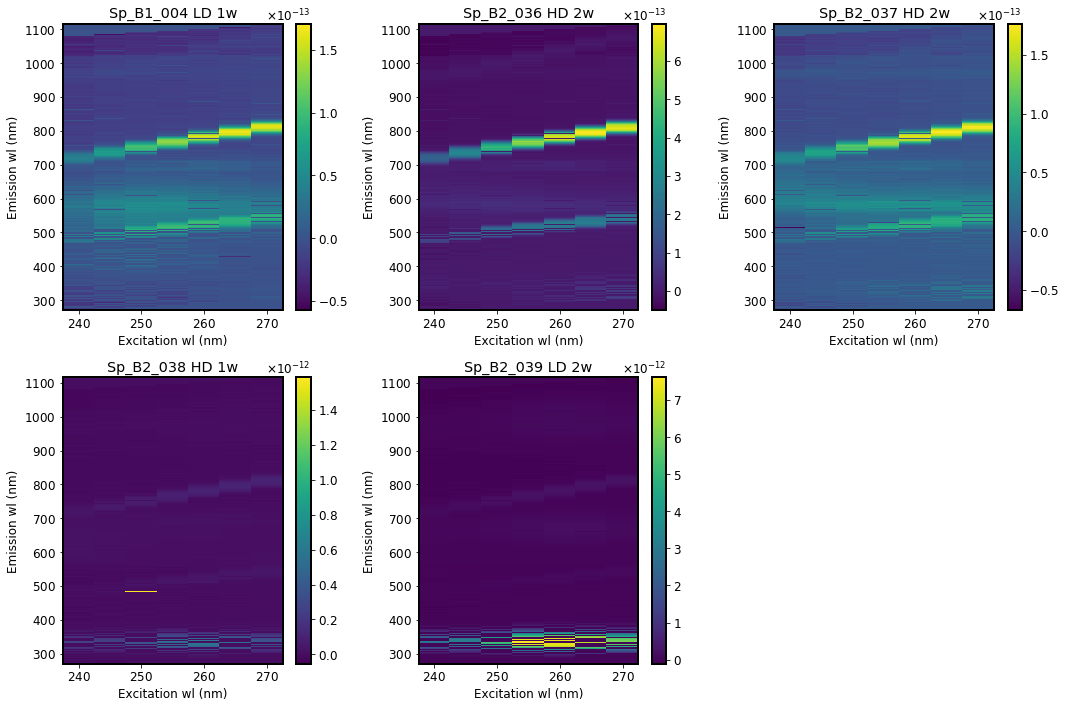

In [65]:
plot_2d(experiment.pre .crystals, "Sp", exposure=10, grating=1)
plot_2d(experiment.post.crystals, "Sp", exposure=10, grating=1)

# Qz

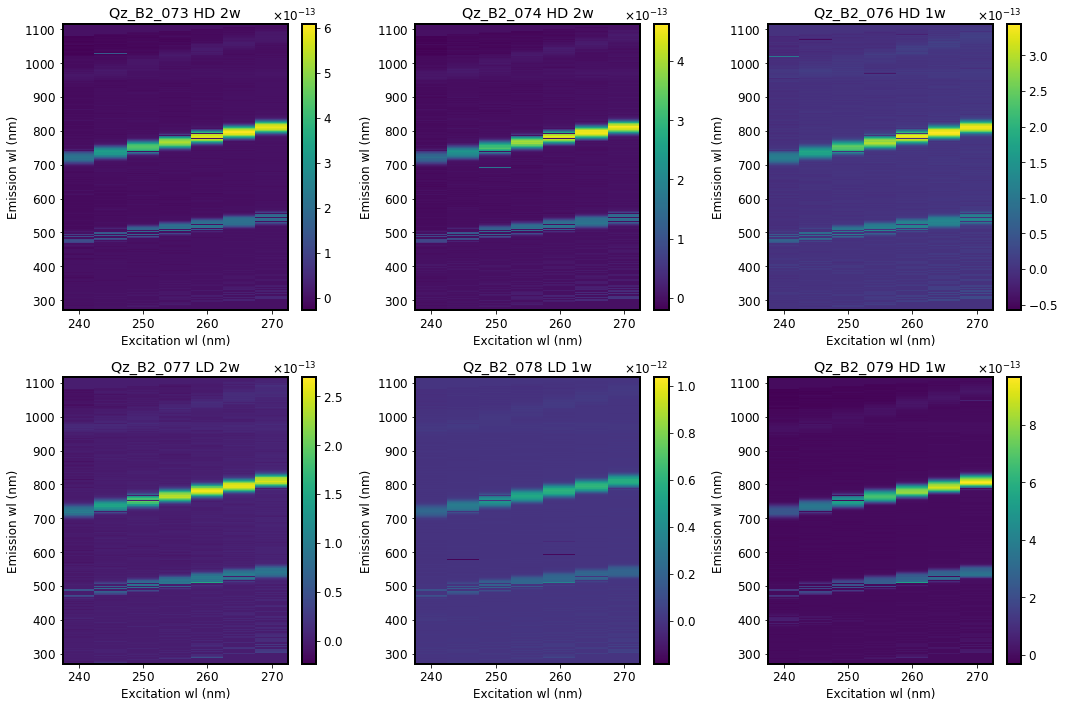

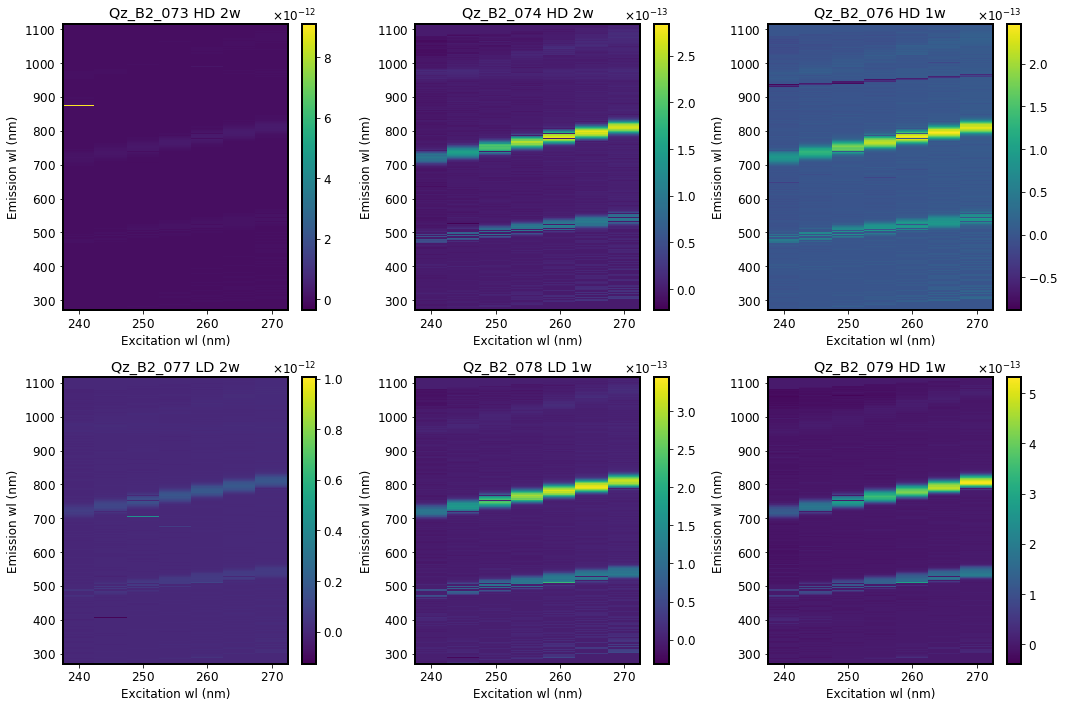

In [66]:
plot_2d(experiment.pre .crystals, "Qz", exposure=10, grating=1)
plot_2d(experiment.post.crystals, "Qz", exposure=10, grating=1)

# CaF

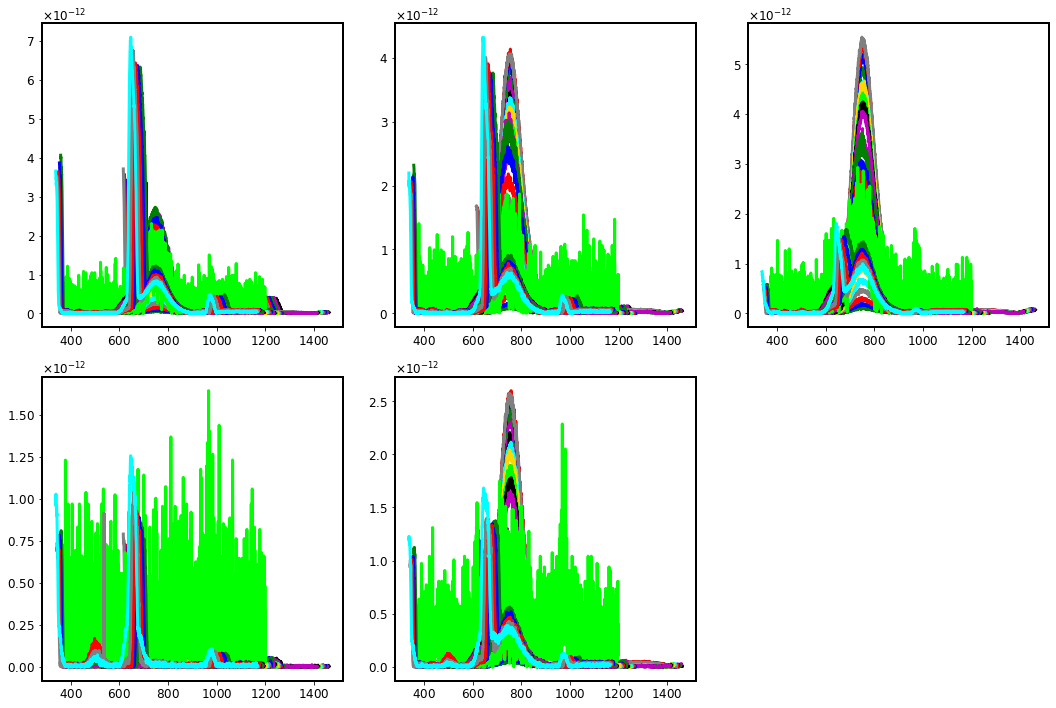

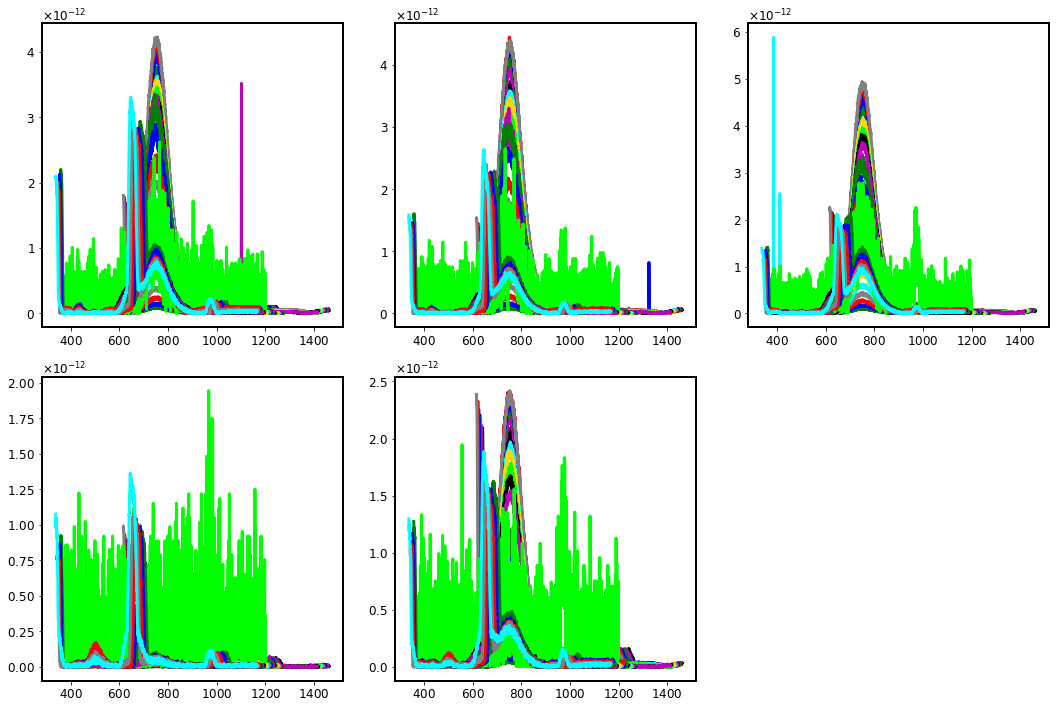

In [95]:
plot_2d(experiment.pre .crystals, "CaF", exposure=1)
plot_2d(experiment.post.crystals, "CaF", exposure=1)

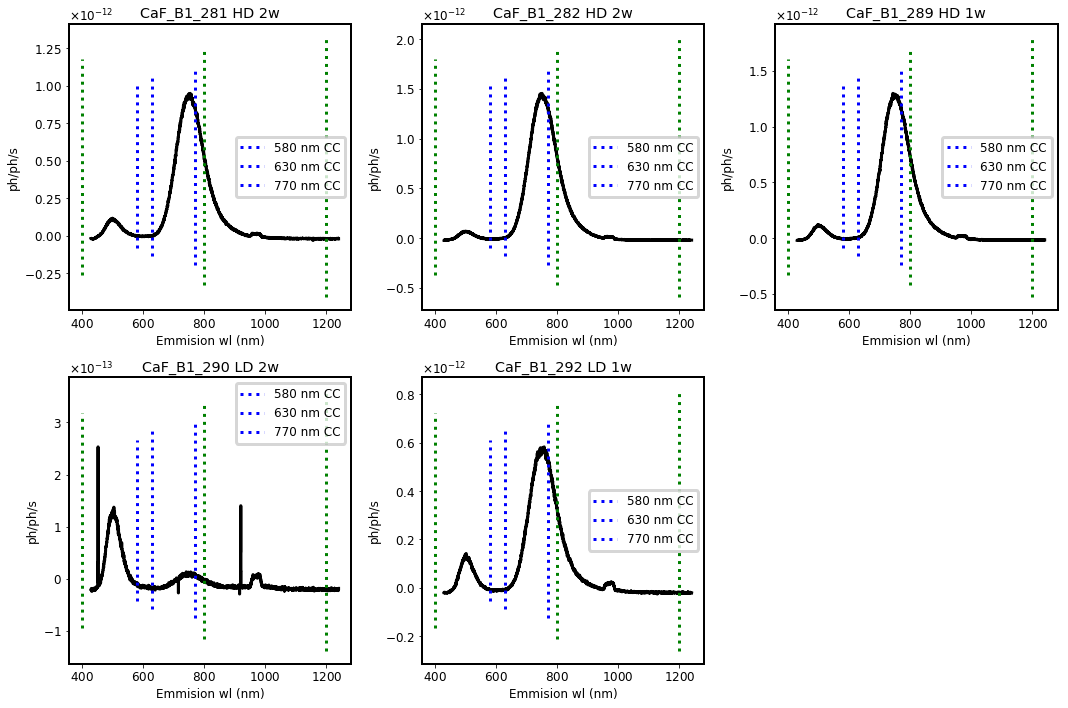

In [10]:
plot_pre("CaF", 400)

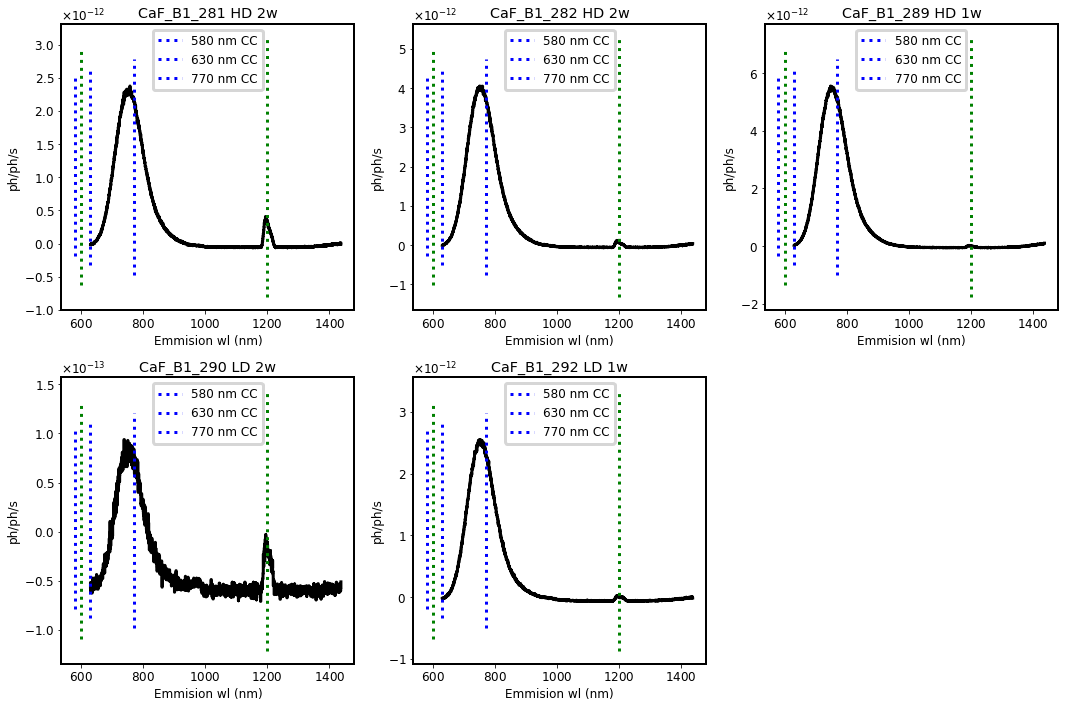

In [11]:
plot_pre("CaF", 600, exposure=1)

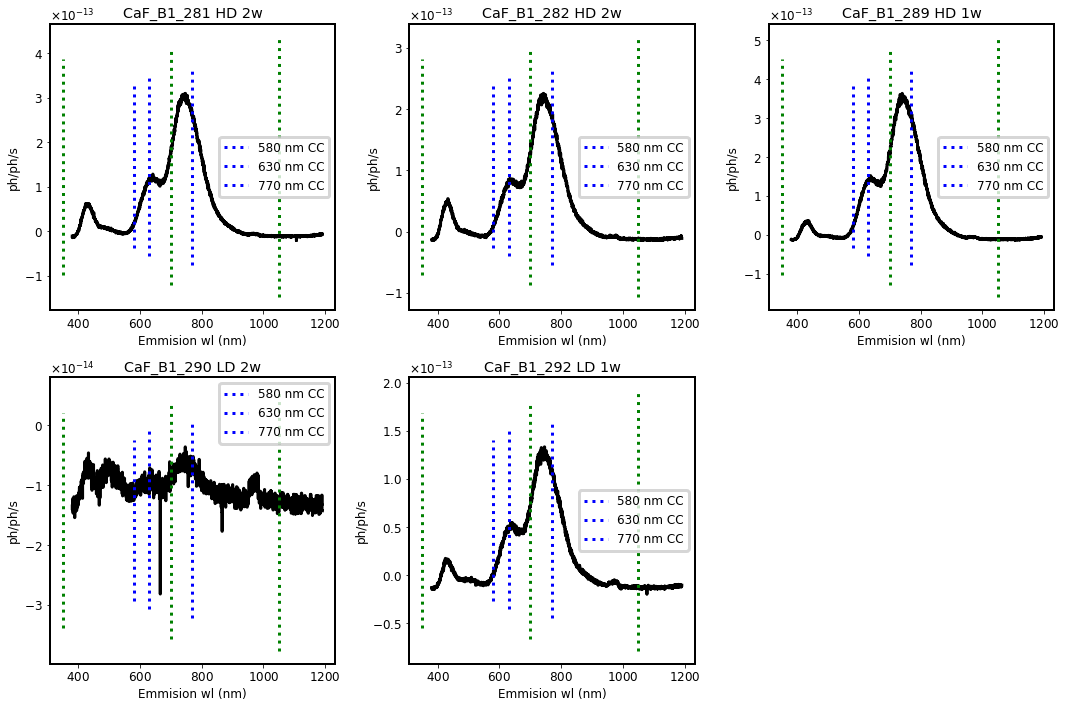

In [12]:
plot_pre("CaF", 350)

# BaF

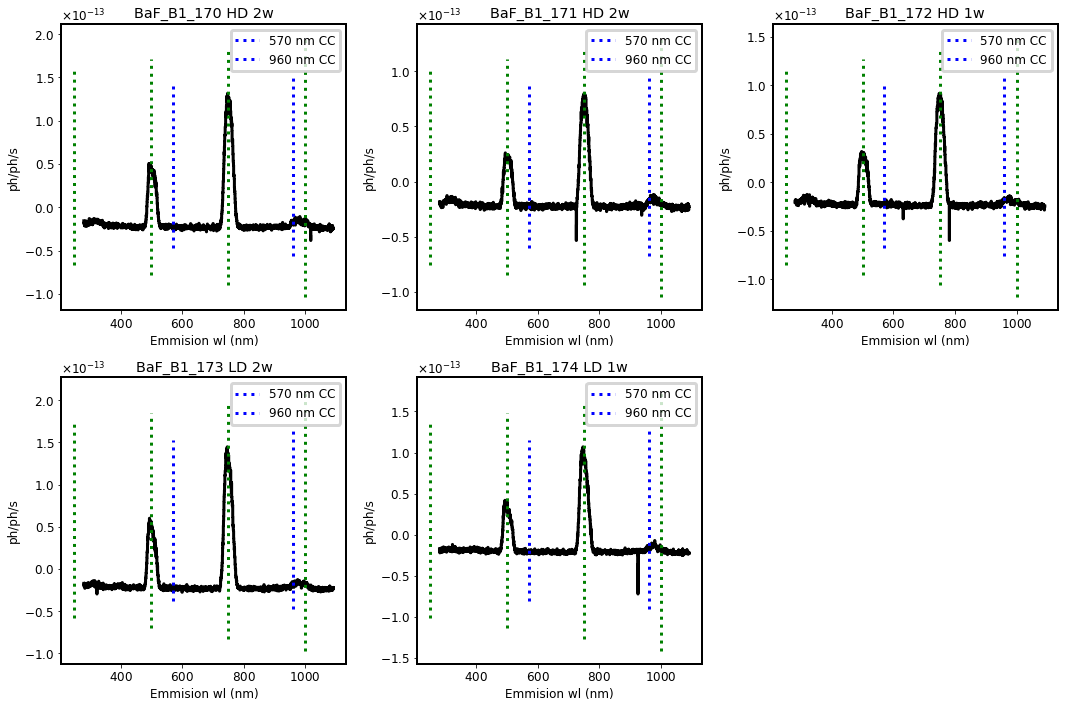

In [13]:
plot_pre("BaF", 250)

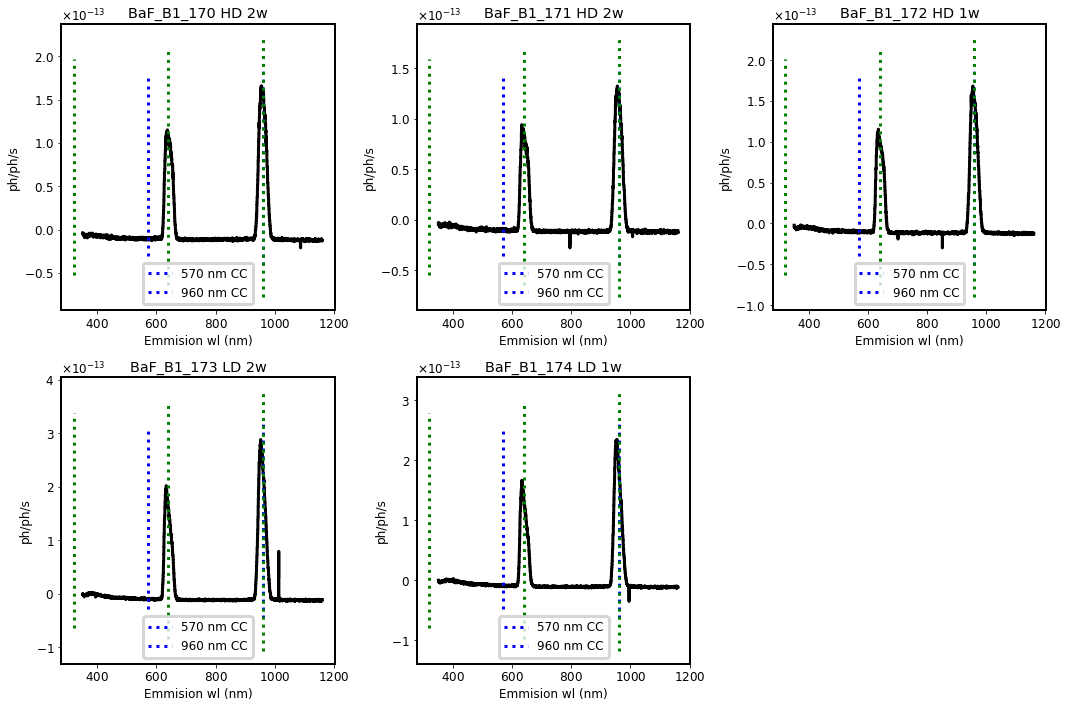

In [14]:
plot_pre("BaF", 320)